# Computational Geometry in Python
reference: 'Discrete and Computational Geometry' (2011) Devadoss and O'Rourke.

In [2]:
%load_ext autoreload
%autoreload 2

import triangle
import numpy as np
import scipy
import scipy.spatial
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
%matplotlib inline
import math
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

/Users/treddy/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## 1) Introduction: What is Computational Geometry? Why is it important?

## 2) Polygons

### 2.1 Definition: 
"A polygon is the closed region of the plane bounded by a finite collection of line segments forming a closed curve that does not intersect itself."

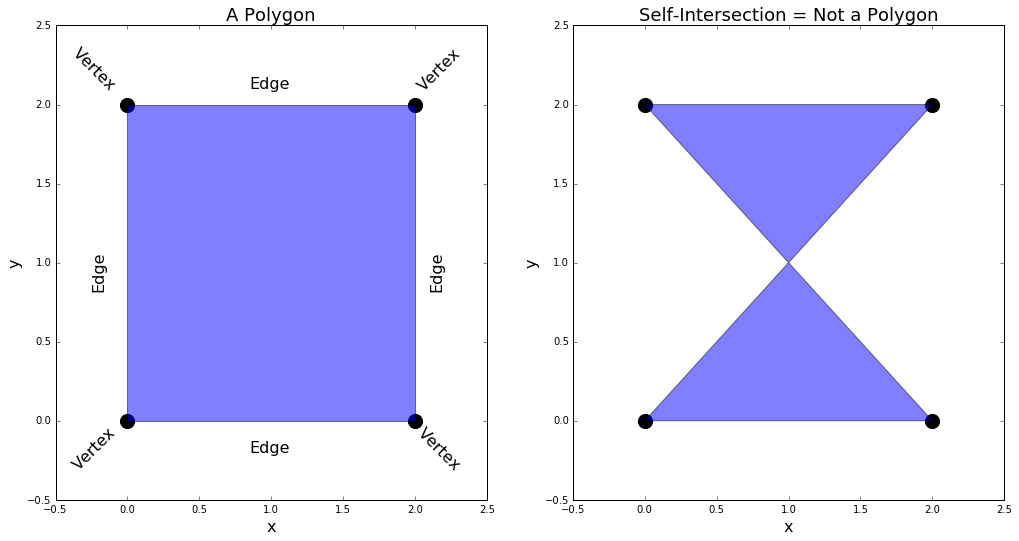

In [6]:
#plot an example of a polygon and an object that fails to be a polygon


fig_2_1 = matplotlib.pyplot.figure()

polygon_vertices = np.array([[0,2], #top left
                             [2,2], #top right
                             [2,0], #bottom right
                             [0,0]]) #bottom left

self_intersection_vertices = np.array([[0,2], #top left
                                       [2,2], #top right
                                       [0,0], #bottom left
                                       [2,0]]) #bottom right

ax = fig_2_1.add_subplot(121)
ax.scatter(polygon_vertices[...,0], polygon_vertices[...,1], color='black', s=200, label = 'vertices')
polygon = Polygon(polygon_vertices, alpha = 0.5)
ax.add_patch(polygon)
ax.set_title('A Polygon', fontsize=18)

ax2 = fig_2_1.add_subplot(122)
ax2.scatter(self_intersection_vertices[...,0], self_intersection_vertices[...,1], color='black', s=200, label = 'vertices')
polygon = Polygon(self_intersection_vertices, alpha = 0.5)
ax2.add_patch(polygon)
ax2.set_title('Self-Intersection = Not a Polygon', fontsize=18)

for axis in [ax,ax2]:
    axis.set_xlabel('x', fontsize = 16)
    axis.set_ylabel('y', fontsize = 16)

#some text labels for the polygon case
ax.text(0.85,2.1,'Edge', fontsize = 16)
ax.text(0.85,-0.2,'Edge', fontsize = 16)
ax.text(-0.25,1.0,'Edge', fontsize = 16, rotation=90)
ax.text(2.1,1.0,'Edge', fontsize = 16, rotation=90)
ax.text(-0.4,2.3,'Vertex', fontsize = 16, rotation=-45)
ax.text(2.0,2.3,'Vertex', fontsize = 16, rotation=45)
ax.text(-0.4,-0.1,'Vertex', fontsize = 16, rotation=45)
ax.text(2.0,-0.1,'Vertex', fontsize = 16, rotation=-45)

fig_2_1.set_size_inches(17,8.5)

### 2.2 Every Polygon Has A Triangulation:

Some useful definitions:
    
1. **Diagonal**: a line segment connecting two vertices of P and lying in the interior of P, not touching $\partial$P except at its endpoints
2. **Triangulation**: a decomposition of P into triangles by a maximal set of noncrossing diagonals

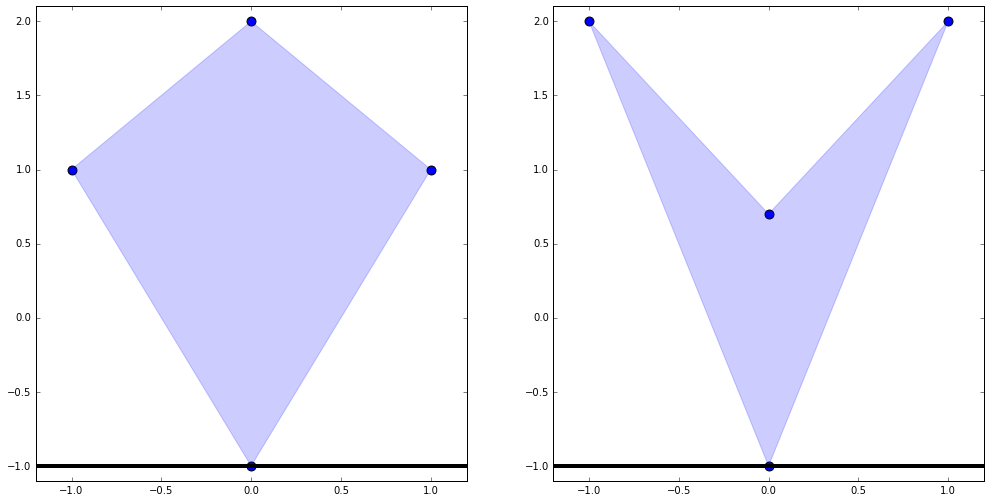

In [7]:
@interact(y_value_p1 = widgets.FloatSlider(min=-1,max=2.1,step=0.1,value=-1),
          y_value_p2 = widgets.FloatSlider(min=-1,max=2.1,step=0.1,value=-1),
          new_diagonal_p2 = False)
def polygon_sweep(y_value_p1, y_value_p2, new_diagonal_p2):
    fig_2_2 = matplotlib.pyplot.figure()
    fig_2_2.set_size_inches(17,8.5)

    polygon_1 = np.array([[0,2],#top
                          [-1,1],#left
                          [0,-1], #bottom
                          [1,1]])#right

    polygon_2 = np.array([[0,0.7],#top
                          [-1,2],#left
                          [0,-1],#bottom
                          [1,2]])#right

    ax1 = fig_2_2.add_subplot(121)
    p1 = Polygon(polygon_1, color='blue', alpha = 0.2)
    ax1.add_patch(p1)
    ax1.scatter(polygon_1[...,0], polygon_1[...,1], s=80)
    ax2 = fig_2_2.add_subplot(122)
    p2 = Polygon(polygon_2, color='blue', alpha = 0.2)
    ax2.add_patch(p2)
    ax2.scatter(polygon_2[...,0], polygon_2[...,1], s=80)

    for axis in [ax1,ax2]:
        axis.set_xlim(-1.2,1.2)
        axis.set_ylim(-1.1,2.1)
    ax1.axhline(y=y_value_p1, lw=4, color = 'black')
    ax2.axhline(y=y_value_p2, lw=4, color = 'black')
    if new_diagonal_p2:
        ax2.axvline(x=0,ymin=0.03,ymax=0.55,color='green',lw=4)

### 2.3 Every triangulation of a polygon with n vertices has n - 2 triangles

Although we will deal with triangulations in greater detail later, here we will use a specific type of triangulation (a **constrained** triangulation) available in the award-winning **Triangle** library to see a demonstration of the above property on some interesting polygons. The Python bindings were written by Dzhelil Rufat--the original **Triangle** library was written by Jonathan Shewchuk (Prof. at UC Berkeley).

In [38]:
import shapefile #Python pyshp library
sf = shapefile.Reader("shapefiles/cb_2015_us_state_20m.shp") #a pain to figure out where / how to download these from Government websites
shapeRecs = sf.shapeRecords()
for shapeRec in shapeRecs:
    if 'Oregon' in shapeRec.record:
        Oregon_vertices = np.array(shapeRec.shape.points)
        
#filter out roughly co-linear points for the purpose of the Triangle library (otherwise get segfault problems)
rows_to_keep = []
index = 0
while index < Oregon_vertices.shape[0] - 1:
    current_x_coord = Oregon_vertices[index,0]
    current_y_coord = Oregon_vertices[index,1]
    next_x_coord = Oregon_vertices[index + 1,0]
    next_y_coord = Oregon_vertices[index + 1,1]
    if abs(current_x_coord - next_x_coord) < 0.001 or abs(current_y_coord - next_y_coord) < 0.001:
        index += 1
        continue
    else:
        rows_to_keep.append(index)
        index += 1
        
Oregon_vertices = Oregon_vertices[rows_to_keep]
Oregon_vertices.shape

(214, 2)

In [39]:
def generate_regular_polygon_vertices(r, n_vertices):
    iteration_values = np.arange(n_vertices)
    angles = 2 * math.pi * iteration_values / float(n_vertices)
    x_coords = r * np.cos(angles)
    y_coords = r * np.sin(angles)
    polygon_coords = np.stack((x_coords, y_coords), axis=-1)
    return polygon_coords

#generate the 65537-gon, which Hermes worked on for 10 years in a 200-page manuscript
polygon_Hermes = generate_regular_polygon_vertices(1.0, 65537)
polygon_Hermes.shape

(65537, 2)

Oregon_vertices.shape: (214, 2)
Oregon num triangles: (212, 3)
65537-gon num triangles: (65535, 3)


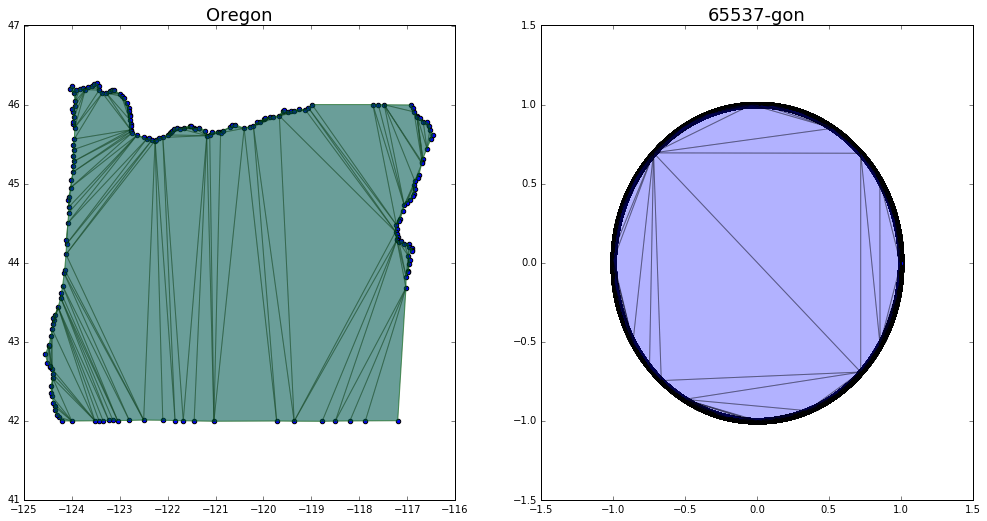

In [40]:
#plot the polygons of interest with interactive widget(s) for triangulation, etc.
from matplotlib.collections import PolyCollection

@interact(triangulate_Oregon= False,
          triangule_Hermes = False)
def triangulation_demo(triangulate_Oregon=False, triangulate_Hermes=False):
    fig_2_3 = plt.figure()
    ax1 = fig_2_3.add_subplot(121)
    ax1.scatter(Oregon_vertices[...,0], Oregon_vertices[...,1])
    p_Oregon = Polygon(Oregon_vertices, color='green', alpha = 0.4)
    ax1.add_patch(p_Oregon)
    ax1.set_title('Oregon', fontsize=18)
    ax2 = fig_2_3.add_subplot(122)
    ax2.scatter(polygon_Hermes[...,0], polygon_Hermes[...,1])
    ax2.set_title('65537-gon', fontsize=18)
    fig_2_3.set_size_inches(17,8.5)
    
    if triangulate_Oregon:
        #need vertex indices for all edges of the polygon
        segment_start_indices = np.arange(Oregon_vertices.shape[0])
        segment_end_indices = segment_start_indices + 1
        segment_end_indices[-1] = 0
        segment_indices = np.array(zip(segment_start_indices, segment_end_indices))
        print 'Oregon_vertices.shape:', Oregon_vertices.shape
        Oregon_vertex_dict = dict(vertices = Oregon_vertices, segments = segment_indices)
        tri = triangle.triangulate(Oregon_vertex_dict, 'p') #'p' for triangulation of planar graph
        print 'Oregon num triangles:', tri['triangles'].shape
        simplex_coords = Oregon_vertices[tri['triangles']]
        triangles = PolyCollection((simplex_coords), alpha = 0.3)
        ax1.add_collection(triangles)
        
    if triangulate_Hermes:
        segment_start_indices = np.arange(polygon_Hermes.shape[0])
        segment_end_indices = segment_start_indices + 1
        segment_end_indices[-1] = 0
        segment_indices = np.array(zip(segment_start_indices, segment_end_indices))
        Hermes_vertex_dict = dict(vertices = polygon_Hermes, segments = segment_indices)
        tri = triangle.triangulate(Hermes_vertex_dict, 'p') #'p' for triangulation of planar graph
        print '65537-gon num triangles:', tri['triangles'].shape
        simplex_coords = polygon_Hermes[tri['triangles']]
        triangles = PolyCollection((simplex_coords), alpha = 0.3)
        ax2.add_collection(triangles)
        
        
        
        